# Part 2: CNN Classification

## Introduction

In this part, you'll implement a Convolutional Neural Network (CNN) for EMNIST character recognition. You can choose between TensorFlow/Keras or PyTorch for implementation. This will help you understand CNNs and their advantages for image classification tasks.

## Learning Objectives

- Implement a CNN using either TensorFlow/Keras or PyTorch
- Apply convolutional layers, pooling, and batch normalization
- Train and evaluate the model
- Save model and metrics in the correct format

## Setup and Installation

In [7]:
# Install required packages
#%pip install -r requirements.txt

# Import necessary libraries
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import tensorflow_datasets as tfds
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Set random seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# Configure matplotlib for better visualization
plt.style.use('seaborn-v0_8-dark-palette')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

# Create directories
os.makedirs('models', exist_ok=True)
os.makedirs('results/part_2', exist_ok=True)
os.makedirs('logs', exist_ok=True)

## 1. Data Loading and Preprocessing

Training data shape: (88800, 28, 28, 1)
Test data shape: (14800, 28, 28, 1)
Number of classes: 26


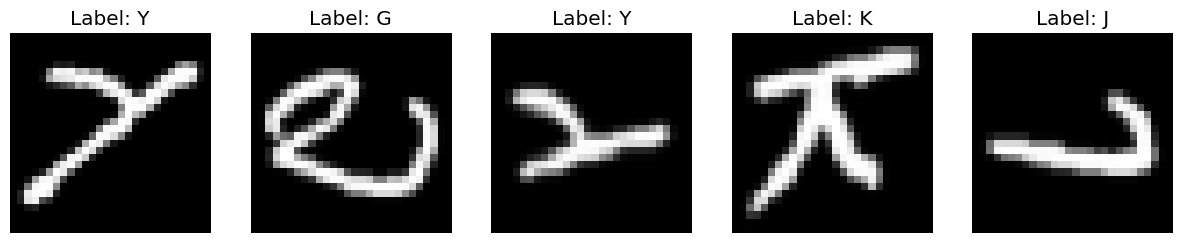

In [9]:
# load the EMNIST dataset
emnist_data = tfds.load('emnist/letters', as_supervised=True)
train_ds, test_ds = emnist_data['train'], emnist_data['test']

# convert to numpy arrays
x_train_list, y_train_list = [], []
for image, label in tfds.as_numpy(train_ds):
    x_train_list.append(image)
    y_train_list.append(label)

x_test_list, y_test_list = [], []
for image, label in tfds.as_numpy(test_ds):
    x_test_list.append(image)
    y_test_list.append(label)

x_train = np.array(x_train_list)
y_train = np.array(y_train_list)
x_test = np.array(x_test_list)
y_test = np.array(y_test_list)

# print dataset information
print(f"Training data shape: {x_train.shape}")
print(f"Test data shape: {x_test.shape}")
print(f"Number of classes: {len(np.unique(y_train))}")

# plot sample images
plt.figure(figsize=(15, 5))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(x_train[i], cmap='gray') 
    plt.title(f'Label: {chr(y_train[i] + 64)}') 
    plt.axis('off')
plt.show()

In [10]:
# Preprocess data
# Normalize pixel values
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Reshape for CNN input (samples, height, width, channels)
x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

# Convert labels to one-hot encoding
y_train = tf.keras.utils.to_categorical(y_train - 1, num_classes=26)
y_test = tf.keras.utils.to_categorical(y_test - 1, num_classes=26)

# Split training data into train and validation
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(
    x_train, y_train, test_size=0.2, random_state=42
)

print(f"Preprocessed training data shape: {x_train.shape}")
print(f"Preprocessed validation data shape: {x_val.shape}")
print(f"Preprocessed test data shape: {x_test.shape}")

Preprocessed training data shape: (71040, 28, 28, 1)
Preprocessed validation data shape: (17760, 28, 28, 1)
Preprocessed test data shape: (14800, 28, 28, 1)


## 2. Model Implementation

### TensorFlow/Keras Implementation

In [11]:
# Create CNN using Keras
def create_cnn_keras(input_shape, num_classes):
    model = tf.keras.Sequential([
        # input layer
        tf.keras.layers.Input(shape=input_shape),
        
        # first convolutional block
        tf.keras.layers.Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Dropout(0.25),
        
        # second convolutional block
        tf.keras.layers.Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Dropout(0.25),
        
        # third convolutional block (helps with more complex features)
        tf.keras.layers.Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Dropout(0.25),
        
        # flatten and dense layers
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.5),
        
        # output layer
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# create and compile model
model = create_cnn_keras(input_shape=(28, 28, 1), num_classes=26)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 28, 28, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 14, 14, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 26)             │         6,682 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 443,002 (1.69 MB)

 Trainable params: 441,850 (1.69 MB)

 Non-trainable params: 1,152 (4.50 KB)

### PyTorch Implementation

In [30]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        
        # first convolutional block
        self.conv1_1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1_1 = nn.BatchNorm2d(32)
        self.conv1_2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.bn1_2 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        self.dropout1 = nn.Dropout2d(0.25)
        
        # second convolutional block
        self.conv2_1 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2_1 = nn.BatchNorm2d(64)
        self.conv2_2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn2_2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        self.dropout2 = nn.Dropout2d(0.25)
        
        # third convolutional block
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(kernel_size=2)
        self.dropout3 = nn.Dropout2d(0.25)
        
        # calculate output size after convolutions and pooling
        self.flatten_size = 128 * 3 * 3
        
        # fully connected layers
        self.fc1 = nn.Linear(self.flatten_size, 256)
        self.bn_fc = nn.BatchNorm1d(256)
        self.dropout_fc = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, num_classes)
    
    def forward(self, x):
        if x.shape[1] != 1 and x.shape[3] == 1:
            x = x.permute(0, 3, 1, 2)
            
        # first block
        x = F.relu(self.bn1_1(self.conv1_1(x)))
        x = F.relu(self.bn1_2(self.conv1_2(x)))
        x = self.pool1(x)
        x = self.dropout1(x)
        
        # second block
        x = F.relu(self.bn2_1(self.conv2_1(x)))
        x = F.relu(self.bn2_2(self.conv2_2(x)))
        x = self.pool2(x)
        x = self.dropout2(x)
        
        # third block
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool3(x)
        x = self.dropout3(x)
        
        # flatten
        x = x.reshape(x.size(0), -1)
        
        # fully connected layers
        x = F.relu(self.bn_fc(self.fc1(x)))
        x = self.dropout_fc(x)
        x = self.fc2(x)
        
        return x

# create model
model = CNN(num_classes=26)
print(model)

CNN(
  (conv1_1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1_1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1_2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1_2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout2d(p=0.25, inplace=False)
  (conv2_1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2_1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2_2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout2d(p=0.25, inplace=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), str

## 3. Training and Evaluation

### TensorFlow/Keras Training

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_15 (Conv2D)              │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 28, 28, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 14, 14, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_23          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 26)             │         6,682 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 443,002 (1.69 MB)

 Trainable params: 441,850 (1.69 MB)

 Non-trainable params: 1,152 (4.50 KB)

Epoch 1/5
2220/2220 ━━━━━━━━━━━━━━━━━━━━ 50s 21ms/step - accuracy: 0.6782 - loss: 1.1116 - val_accuracy: 0.9144 - val_loss: 0.2490 - learning_rate: 0.0010
Epoch 2/5
2220/2220 ━━━━━━━━━━━━━━━━━━━━ 74s 33ms/step - accuracy: 0.8890 - loss: 0.3364 - val_accuracy: 0.9299 - val_loss: 0.2025 - learning_rate: 0.0010
Epoch 3/5
2220/2220 ━━━━━━━━━━━━━━━━━━━━ 66s 30ms/step - accuracy: 0.9044 - loss: 0.2812 - val_accuracy: 0.9383 - val_loss: 0.1737 - learning_rate: 0.0010
Epoch 4/5
2220/2220 ━━━━━━━━━━━━━━━━━━━━ 66s 30ms/step - accuracy: 0.9120 - loss: 0.2568 - val_accuracy: 0.9404 - val_loss: 0.1730 - learning_rate: 0.0010
Epoch 5/5
2220/2220 ━━━━━━━━━━━━━━━━━━━━ 70s 31ms/step - accuracy: 0.9194 - loss: 0.2308 - val_accuracy: 0.9431 - val_loss: 0.1614 - learning_rate: 0.0010


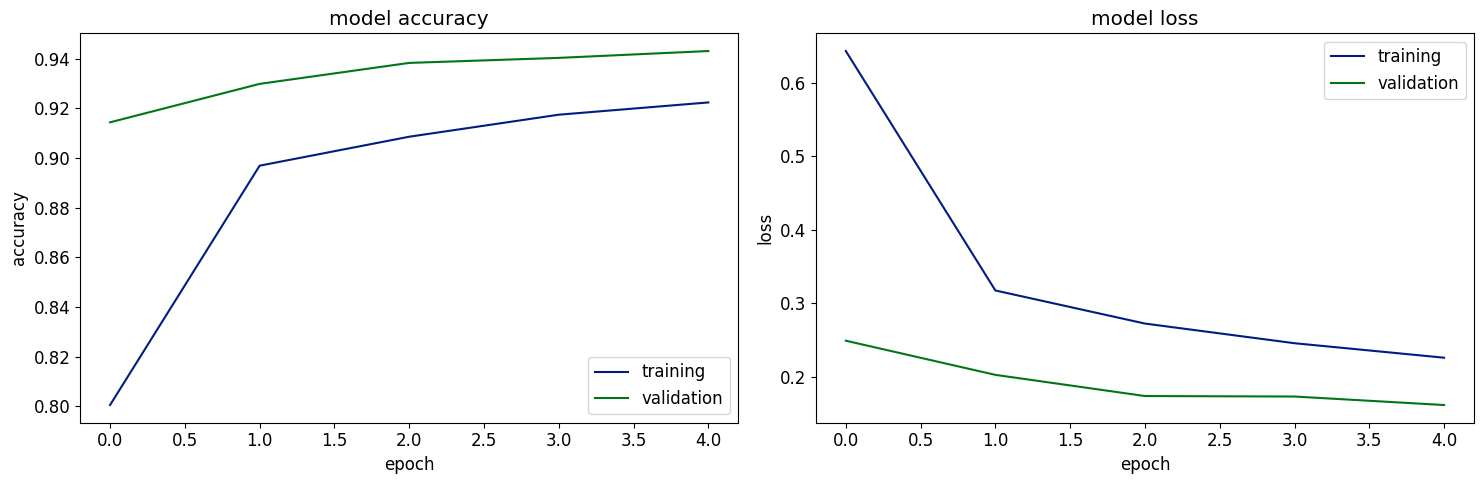

463/463 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.9319 - loss: 0.1963
test accuracy: 0.9312
463/463 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step


c:\Users\mihir\OneDrive\Desktop\DataSci223\6-neural-nets-MihirUCSF\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


precision: 0.7142
recall: 0.7089
f1 score: 0.7107


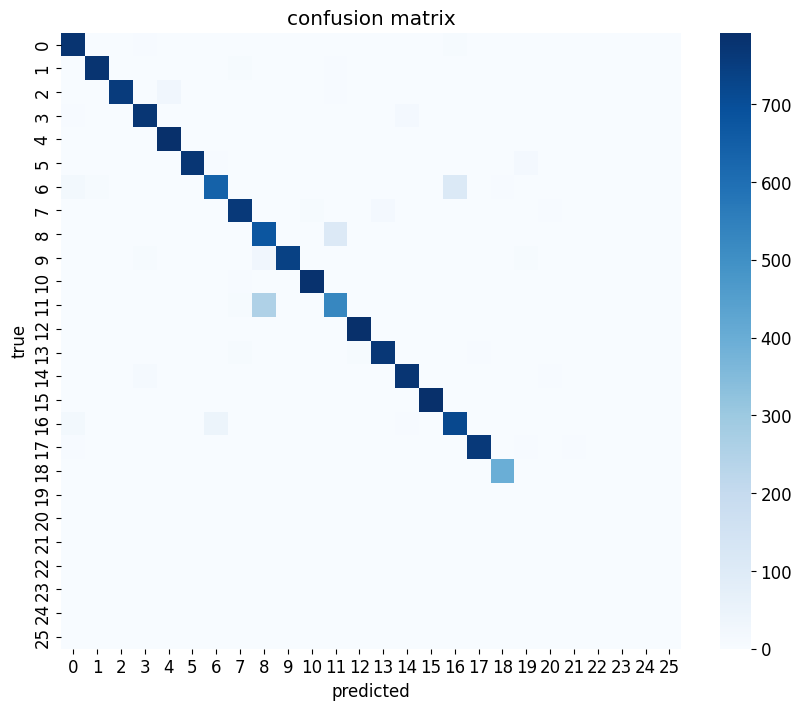

In [19]:
# Keras model training and evaluation
# Create the Keras model
model = create_cnn_keras(input_shape=(28, 28, 1), num_classes=26)
model.summary()

# define callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=3
    ),
    tf.keras.callbacks.ModelCheckpoint(
        'models/cnn_keras.keras',
        save_best_only=True
    )
]

# train model
history = model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=5,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)

# plot training curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# plot accuracy
ax1.plot(history.history['accuracy'], label='training')
ax1.plot(history.history['val_accuracy'], label='validation')
ax1.set_title('model accuracy')
ax1.set_xlabel('epoch')
ax1.set_ylabel('accuracy')
ax1.legend()

# plot loss
ax2.plot(history.history['loss'], label='training')
ax2.plot(history.history['val_loss'], label='validation')
ax2.set_title('model loss')
ax2.set_xlabel('epoch')
ax2.set_ylabel('loss')
ax2.legend()

plt.tight_layout()
plt.show()

# model evaluation 
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print(f"test accuracy: {test_accuracy:.4f}")

# get predictions
predictions = model.predict(x_test)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(y_test, axis=1)

# calculate metrics
precision = precision_score(true_labels, predicted_labels, average='macro')
recall = recall_score(true_labels, predicted_labels, average='macro')
f1 = f1_score(true_labels, predicted_labels, average='macro')

print(f"precision: {precision:.4f}")
print(f"recall: {recall:.4f}")
print(f"f1 score: {f1:.4f}")

# calculate confusion matrix
cm = tf.math.confusion_matrix(true_labels, predicted_labels)

# plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=False, cmap='Blues')
plt.title('confusion matrix')
plt.xlabel('predicted')
plt.ylabel('true')
plt.show()

# save metrics
metrics = {
    'model': 'cnn_emnist_classifier',
    'accuracy': float(test_accuracy),
    'precision': float(precision),
    'recall': float(recall),
    'f1_score': float(f1)
}

# save to file
with open('results/part_2/cnn_emnist_metrics.txt', 'w') as f:
    f.write(f"model: {metrics['model']}\n")
    f.write(f"accuracy: {metrics['accuracy']}\n")
    f.write(f"precision: {metrics['precision']}\n")
    f.write(f"recall: {metrics['recall']}\n")
    f.write(f"f1_score: {metrics['f1_score']}\n")
    f.write("----\n")

### PyTorch Training

In [31]:
# Move model to device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device) 

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

# Check if data is already a tensor
if isinstance(y_train, torch.Tensor):
    print("Data is already in PyTorch tensor format")
    y_train_torch = y_train.long().to(device)
    y_val_torch = y_val.long().to(device)
    x_train_torch = x_train.to(device)
    x_val_torch = x_val.to(device)
else:
    print("Converting data to PyTorch tensors")
    # Convert data to PyTorch tensors
    x_train_torch = torch.FloatTensor(x_train).to(device)
    
    # Convert from one-hot to indices if necessary
    if len(y_train.shape) > 1:
        y_train_torch = torch.LongTensor(np.argmax(y_train, axis=1)).to(device)
        y_val_torch = torch.LongTensor(np.argmax(y_val, axis=1)).to(device)
    else:
        y_train_torch = torch.LongTensor(y_train).to(device)
        y_val_torch = torch.LongTensor(y_val).to(device)
    
    x_val_torch = torch.FloatTensor(x_val).to(device)

# Print tensor shapes to verify
print(f"x_train_torch shape: {x_train_torch.shape}")
print(f"y_train_torch shape: {y_train_torch.shape}")
print(f"x_val_torch shape: {x_val_torch.shape}")
print(f"y_val_torch shape: {y_val_torch.shape}")

Data is already in PyTorch tensor format
x_train_torch shape: torch.Size([71040, 28, 28, 1])
y_train_torch shape: torch.Size([71040])
x_val_torch shape: torch.Size([17760, 28, 28, 1])
y_val_torch shape: torch.Size([17760])


epoch 1/5:
train loss: 0.5984, train acc: 0.8181
val loss: 0.2085, val acc: 0.9269
saved best model
epoch 2/5:
train loss: 0.3196, train acc: 0.8949
val loss: 0.1746, val acc: 0.9389
saved best model
epoch 3/5:
train loss: 0.2737, train acc: 0.9101
val loss: 0.1678, val acc: 0.9395
saved best model
epoch 4/5:
train loss: 0.2481, train acc: 0.9168
val loss: 0.1643, val acc: 0.9414
saved best model
epoch 5/5:
train loss: 0.2304, train acc: 0.9227
val loss: 0.1557, val acc: 0.9441
saved best model


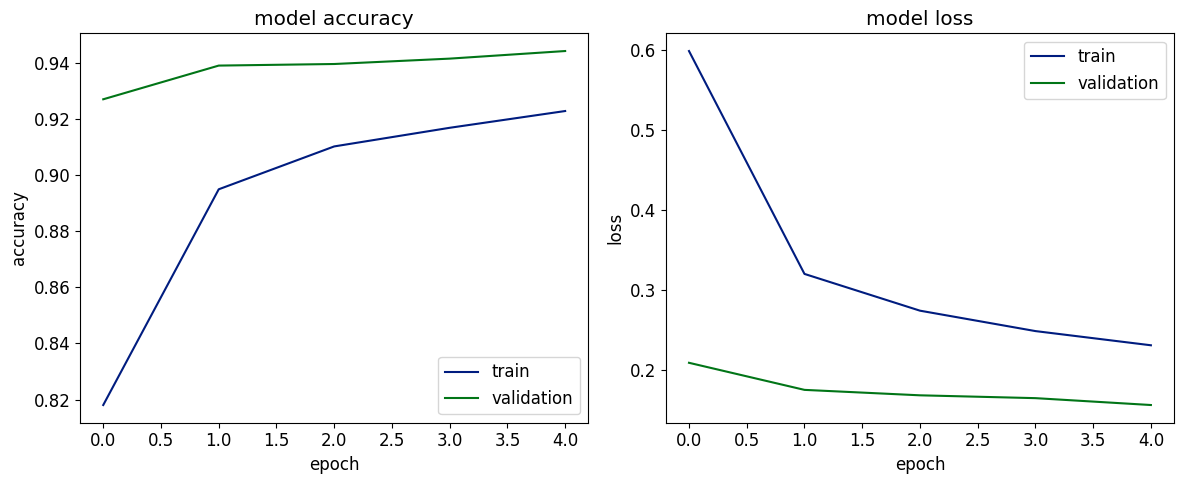

c:\Users\mihir\OneDrive\Desktop\DataSci223\6-neural-nets-MihirUCSF\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


test accuracy: 0.9329
test loss: 0.1872
precision: 0.6870
recall: 0.6826
f1 score: 0.6844


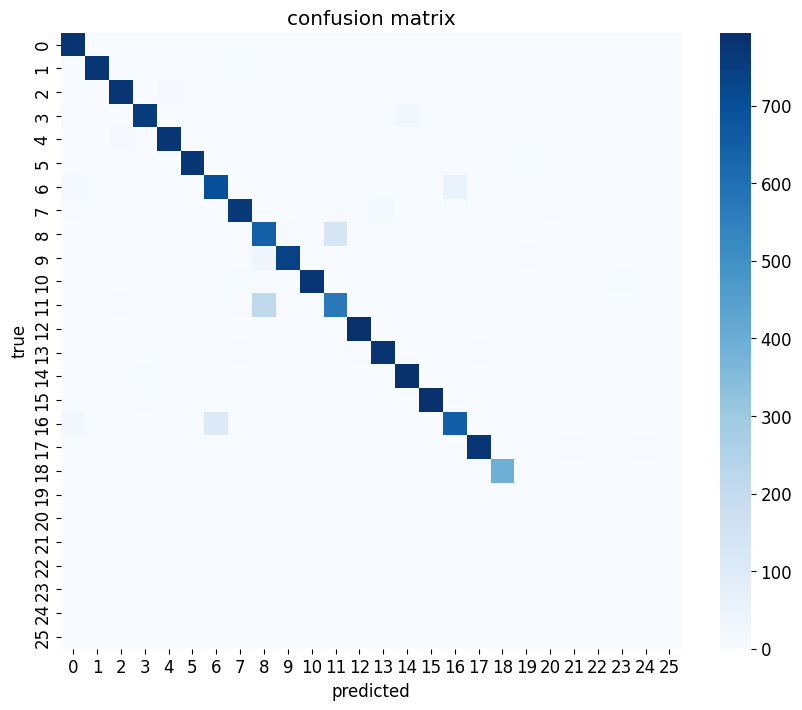

In [35]:
# Create the PyTorch model
model = CNN(num_classes=26)

# Move model to device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Convert data to PyTorch tensors
# Handle one-hot encoded labels
y_train_indices = np.argmax(y_train, axis=1) if len(y_train.shape) > 1 else y_train
y_val_indices = np.argmax(y_val, axis=1) if len(y_val.shape) > 1 else y_val

# Convert data to PyTorch tensors
x_train_torch = torch.FloatTensor(x_train).to(device)
y_train_torch = torch.LongTensor(y_train_indices).to(device)
x_val_torch = torch.FloatTensor(x_val).to(device)
y_val_torch = torch.LongTensor(y_val_indices).to(device)

# training parameters
batch_size = 32
num_epochs = 5  # reduced from 10 to 5
patience = 5  # early stopping patience

# lists to store metrics
train_losses = []
train_accs = []
val_losses = []
val_accs = []

# early stopping variables
best_val_loss = float('inf')
patience_counter = 0

# training loop
for epoch in range(num_epochs):
    # training phase
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    # process in batches
    for i in range(0, len(x_train_torch), batch_size):
        # get batch
        batch_x = x_train_torch[i:i+batch_size]
        batch_y = y_train_torch[i:i+batch_size]
        
        # zero the gradients
        optimizer.zero_grad()
        
        # forward pass
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        
        # backward pass and optimize
        loss.backward()
        optimizer.step()
        
        # statistics
        running_loss += loss.item() * batch_x.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += batch_y.size(0)
        correct += (predicted == batch_y).sum().item()
        
    # calculate epoch metrics
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    train_losses.append(epoch_loss)
    train_accs.append(epoch_acc)
    
    # validation phase
    model.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():  # no gradients needed for validation
        for i in range(0, len(x_val_torch), batch_size):
            # get batch
            batch_x = x_val_torch[i:i+batch_size]
            batch_y = y_val_torch[i:i+batch_size]
            
            # forward pass
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            
            # statistics
            val_running_loss += loss.item() * batch_x.size(0)
            _, predicted = torch.max(outputs.data, 1)
            val_total += batch_y.size(0)
            val_correct += (predicted == batch_y).sum().item()
    
    # calculate validation metrics
    val_epoch_loss = val_running_loss / val_total
    val_epoch_acc = val_correct / val_total
    val_losses.append(val_epoch_loss)
    val_accs.append(val_epoch_acc)
    
    # print epoch results
    print(f'epoch {epoch+1}/{num_epochs}:')
    print(f'train loss: {epoch_loss:.4f}, train acc: {epoch_acc:.4f}')
    print(f'val loss: {val_epoch_loss:.4f}, val acc: {val_epoch_acc:.4f}')
    
    # early stopping check
    if val_epoch_loss < best_val_loss:
        best_val_loss = val_epoch_loss
        patience_counter = 0
        # save the best model
        torch.save(model.state_dict(), 'models/cnn_pytorch.pt')
        print("saved best model")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"early stopping at epoch {epoch+1}")
            break

# plot training curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_accs, label='train')
plt.plot(val_accs, label='validation')
plt.title('model accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_losses, label='train')
plt.plot(val_losses, label='validation')
plt.title('model loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()

plt.tight_layout()
plt.show()

# load the best model for evaluation
model.load_state_dict(torch.load('models/cnn_pytorch.pt'))
model.eval()

# prepare test data
x_test_torch = torch.FloatTensor(x_test).to(device)
y_test_indices = np.argmax(y_test, axis=1)
y_test_torch = torch.LongTensor(y_test_indices).to(device)

# test evaluation
test_loss = 0.0
test_correct = 0
test_total = 0

# evaluate in batches
all_predictions = []
with torch.no_grad():
    for i in range(0, len(x_test_torch), batch_size):
        # get batch
        batch_x = x_test_torch[i:i+batch_size]
        batch_y = y_test_torch[i:i+batch_size]
        
        # forward pass
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        
        # statistics
        test_loss += loss.item() * batch_x.size(0)
        _, predicted = torch.max(outputs.data, 1)
        test_total += batch_y.size(0)
        test_correct += (predicted == batch_y).sum().item()
        
        # store predictions for metrics
        all_predictions.append(predicted.cpu().numpy())

# calculate test metrics
test_accuracy = test_correct / test_total
test_loss = test_loss / test_total

# combine all predictions
all_predictions = np.concatenate(all_predictions)

# calculate additional metrics
precision = precision_score(y_test_indices, all_predictions, average='macro')
recall = recall_score(y_test_indices, all_predictions, average='macro')
f1 = f1_score(y_test_indices, all_predictions, average='macro')

print(f"test accuracy: {test_accuracy:.4f}")
print(f"test loss: {test_loss:.4f}")
print(f"precision: {precision:.4f}")
print(f"recall: {recall:.4f}")
print(f"f1 score: {f1:.4f}")

# confusion matrix
cm = confusion_matrix(y_test_indices, all_predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=False, cmap='Blues')
plt.title('confusion matrix')
plt.xlabel('predicted')
plt.ylabel('true')
plt.show()

# save metrics to file
metrics = {
    'model': 'cnn_pytorch_emnist',
    'accuracy': float(test_accuracy),
    'precision': float(precision),
    'recall': float(recall),
    'f1_score': float(f1)
}

with open('results/part_2/cnn_pytorch_metrics.txt', 'w') as f:
    f.write(f"model: {metrics['model']}\n")
    f.write(f"accuracy: {metrics['accuracy']}\n")
    f.write(f"precision: {metrics['precision']}\n")
    f.write(f"recall: {metrics['recall']}\n")
    f.write(f"f1_score: {metrics['f1_score']}\n")
    f.write("----\n")

## Progress Checkpoints

1. **Data Loading**:
   - [ ] Successfully load EMNIST dataset
   - [ ] Verify data shapes and ranges
   - [ ] Visualize sample images

2. **Preprocessing**:
   - [ ] Normalize pixel values
   - [ ] Reshape data for CNN input
   - [ ] Convert labels to one-hot encoding

3. **Model Implementation**:
   - [ ] Create CNN with required layers
   - [ ] Verify architecture requirements
   - [ ] Test model with sample input

4. **Training**:
   - [ ] Train model with callbacks
   - [ ] Monitor training progress
   - [ ] Save best model

5. **Evaluation**:
   - [ ] Calculate performance metrics
   - [ ] Save metrics in correct format
   - [ ] Visualize results

## Common Issues and Solutions

1. **Data Loading Issues**:
   - Problem: EMNIST dataset not found
   - Solution: Check internet connection and TensorFlow installation

2. **Preprocessing Issues**:
   - Problem: Shape mismatch in CNN layers
   - Solution: Ensure data is properly shaped (samples, height, width, channels)
   - Problem: Label encoding errors
   - Solution: Verify label range and one-hot encoding

3. **Model Issues**:
   - Problem: Training instability
   - Solution: Add batch normalization, reduce learning rate
   - Problem: Overfitting
   - Solution: Increase dropout, use data augmentation

4. **Evaluation Issues**:
   - Problem: Metrics format incorrect
   - Solution: Follow the exact format specified
   - Problem: Performance below threshold
   - Solution: Adjust architecture, hyperparameters